In [16]:
import torch
import os
from data.datasets import SegmentationDataset
from models.encoder import ViTEncoder
from models.decoders import SegmentationDecoder
from torch.utils.data import DataLoader
from eval_utils import get_mask
from eval_utils import compute_metrics
import matplotlib.pyplot as plt

In [17]:
MODE = ['e2e', 'frozen']
DATA_SIZE = ['2000', '160', '80', '40', '20', '10']
MODEL_PATH = './checkpoints'
DATA_PATH  = '../ISIC2017_resized/'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
test_data = DataLoader(
    dataset=SegmentationDataset(
        image_dir= DATA_PATH+"test_images/",
        mask_dir=DATA_PATH+"test_seg_masks/",
        size=1
    ),
    batch_size=1,
)

In [19]:
res = dict()
for ds in DATA_SIZE:
    for m in MODE:
        print()
        # print('----------------------------------------')
        model_name = 'seg_' + m + '_' + ds
        model_dict = torch.load(os.path.join(MODEL_PATH, model_name+".pth"))

        # print("Loading Model Paramters for {s} ...".format(s=model_name))
        decoder = SegmentationDecoder().to(DEVICE)
        decoder.load_state_dict(model_dict['decoder_state_dict'])
        encoder = ViTEncoder().to(DEVICE)
        encoder.load_state_dict(model_dict['encoder_state_dict'])

        key = m[0].upper()+ds
        print(model_name)
        for images, masks in test_data:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            _, features = encoder(images)  # get feature map
            output = decoder(features)
            pred = get_mask(output)
            met = compute_metrics(pred=output, mask=masks, threshold=0.5)
            res[(m, ds)] = (met[0][0].item(), pred.squeeze(0).squeeze(0).cpu().numpy())


seg_e2e_2000

seg_frozen_2000

seg_e2e_160

seg_frozen_160

seg_e2e_80

seg_frozen_80

seg_e2e_40

seg_frozen_40

seg_e2e_20

seg_frozen_20

seg_e2e_10

seg_frozen_10


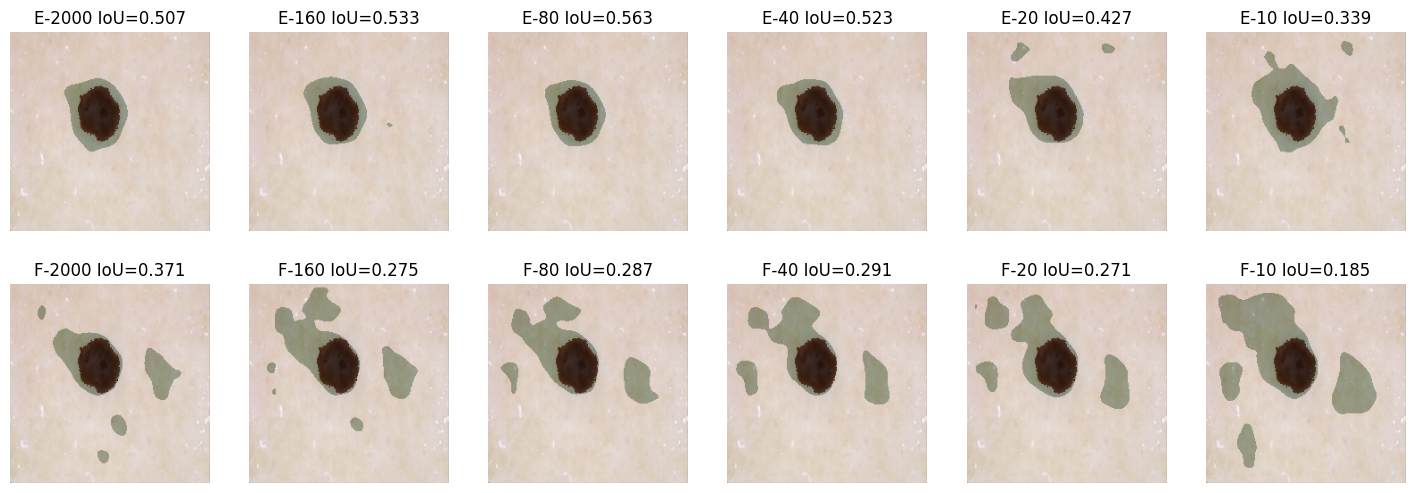

In [20]:
img = None
gtm = None
for images, masks in test_data:
    img, gtm = images, masks
    break
img = img.squeeze(0)
gtm = gtm.squeeze(0)
img = img.permute(1, 2, 0).numpy()
gtm = gtm.squeeze(0).numpy()

fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.flatten()

i = 0
for m in MODE:
    for ds in DATA_SIZE:
        met, pred = res[(m, ds)]
        ax = axes[i]
        ax.imshow(img)
        ax.imshow(gtm, cmap='Reds', alpha=0.5)
        ax.imshow(pred, cmap='Greens', alpha=0.3)
        ax.set_title(m[0].upper()+'-'+ds+" IoU={f}".format(f=round(met,3)))
        ax.axis('off')
        i += 1